# Data Science Case - F&E

In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

## Load the data

In [2]:
def load_data(bauteile_path, verbrauch_path):
    bauteile_files = glob(os.path.join(bauteile_path, "*.csv"))
    verbrauch_data = pd.read_csv(verbrauch_path)
    
    """
    Load data from given paths.
    
    Parameters:
    bauteile_path (str): Path to the directory containing bauteile CSV files.
    verbrauch_path (str): Path to the verbrauch CSV file.

    Returns:
    tuple: bauteile_data (DataFrame), verbrauch_data (DataFrame)
    """
    bauteile_data = []
    for file in bauteile_files:
        house_data = pd.read_csv(file)
        house_data['cenarius_product_id'] = os.path.basename(file).replace('.csv', '')
        bauteile_data.append(house_data)
    bauteile_data = pd.concat(bauteile_data, ignore_index=True)
    
    return bauteile_data, verbrauch_data

# File-paths
bauteile_path = './data/bauteile'
verbrauch_path = './data/verbrauch/verbrauch.csv'

bauteile_data, verbrauch_data = load_data(bauteile_path, verbrauch_path)

/var/folders/mk/f2kz1sjn3s91f64hrrgq01lc0000gn/T/ipykernel_77659/1769563454.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bauteile_data = pd.concat(bauteile_data, ignore_index=True)


## Preprocess the data

#### I want to extract the information out of the column LongDescBmElement to differentiate between Roof, Window, etc.

### Bauteile

In [3]:

def categorize_long_desc(element):

    """
    Categorize the long description of building elements.
    
    Parameters:
    element (str): The description of the building element.

    Returns:
    str: Categorized building element.
    """
    if pd.isna(element):
        return 'Unknown'
    element = element.lower()
    if 'dach' in element:
        return 'Dach'
    if 'boden' in element:
        return 'Boden'
    if 'decke' in element:
        return 'Decke'
    if 'aw' in element:
        return 'Außenwand'
    if 'wand' in element:
        return 'Wand'
    if 'fenster' in element or element.startswith('f '):
        return 'Fenster'
    if 'anbau' in element:
        return 'Anbau'
    if 'denkmal' in element:
        return 'Denkmal'
    if 'eg' in element:
        return 'EG'
    if 'iw' in element:
        return 'IW'
    if 'at' in element:
        return 'AT'
    return 'Other'

def extract_building_elements(df):
    """
    Extract building elements from the data.
    
    Parameters:
    df (DataFrame): The input dataframe.

    Returns:
    DataFrame: DataFrame with extracted building elements.
    """
    def get_bauteil(element):
        try:
            return categorize_long_desc(element)
        except IndexError:
            return 'Unknown'

    def get_floor(element):
        try:
            parts = element.split(' ')
            if len(parts) > 1:
                if '-' in parts[1]:
                    return parts[1].split('-')[0]
                else:
                    return parts[1]
            else:
                return 'Unknown'
        except IndexError:
            return 'Unknown'

    def get_roomnumber(element):
        try:
            parts = element.split(' ')
            if len(parts) > 1:
                if '-' in parts[1]:
                    return parts[1]
                else:
                    return 'Unknown'
            else:
                return 'Unknown'
        except IndexError:
            return 'Unknown'

    df['Bauteil'] = df['LongDescBmElement'].apply(lambda x: get_bauteil(x) if pd.notna(x) else 'Unknown')
    df['Floor'] = df['LongDescBmElement'].apply(lambda x: get_floor(x) if pd.notna(x) else 'Unknown')
    df['RoomNumber'] = df['LongDescBmElement'].apply(lambda x: get_roomnumber(x) if pd.notna(x) else 'Unknown')

    return df


In [4]:
# Apply the function to the data
bauteile_data = extract_building_elements(bauteile_data)

# Drop RoomNumber and Floor columns
bauteile_data.drop(columns=['Floor', 'RoomNumber', 'LongDescBmElement', 'Unnamed: 0'], inplace=True)

# Onehot-encode the column AdjacentTypeBoolean and call it gegen_aussen
bauteile_data['gegen_aussen'] = bauteile_data['AdjacentTypeBoolean'].apply(lambda x: 1 if x == 'Gegen Aussen' else 0)
bauteile_data.drop(columns=['AdjacentTypeBoolean'], inplace=True)

# Set UUID as index
bauteile_data.set_index('UUID', inplace=True)

# Replace values outside the range of 0 & 360 with NaN
bauteile_data['Orientation'] = bauteile_data['Orientation'].apply(lambda x: x if 0 <= x <= 360 else np.nan)

# Group data by 'cenarius_product_id' and 'Bauteil'
grouped_data = bauteile_data.groupby(['cenarius_product_id', 'Bauteil']).agg({
    'NetArea': 'sum',
    'UValue': 'mean',
    'DeltaTemperature': 'mean',
    'GroupType': 'first'
}).reset_index()

# Flatten the grouped data
grouped_data.columns = ['cenarius_product_id', 'Bauteil', 'NetArea_sum', 'UValue_mean', 'DeltaTemperature_mean', 'GroupType']

# Pivot the table to get Bauteil-specific columns
pivot_data = grouped_data.pivot(index='cenarius_product_id', columns='Bauteil').fillna(0)

# Flatten the multi-index columns
pivot_data.columns = ['_'.join(col).strip() for col in pivot_data.columns.values]

# Reset the index to make 'cenarius_product_id' a column again
pivot_data.reset_index(inplace=True)

# Save the pivot_data to a csv file to check the results
pivot_data.to_csv('./data/bauteile_pivot.csv', index=False)

In [5]:
# Check percentage of zero values in each column
zero_percentage = pivot_data.apply(lambda x: (x == 0).mean() * 100)

# Drop columns with more than 90% zeros
columns_to_drop = zero_percentage[zero_percentage > 90].index
pivot_data.drop(columns=columns_to_drop, inplace=True)

### Verbrauchsdaten

In [6]:
# Handling 0 and negative values for verbrauch data. Set the mean value for NaN values
def clean_verbrauch_data(df):
    """
    Clean verbrauch data by replacing negative values and handling NaNs.
    
    Parameters:
    df (DataFrame): The input dataframe.

    Returns:
    DataFrame: Cleaned dataframe.
    """
    df['verbrauch (kWh/a)'] = df['verbrauch (kWh/a)'].apply(lambda x: max(x, 0))
    
    # Check if all values are zero or NaN, set mean to 1 to avoid mean of zero
    if df['verbrauch (kWh/a)'].eq(0).all():
        mean_value = 1
    else:
        mean_value = df['verbrauch (kWh/a)'].mean()

    # Fill NaN values with the mean of the non-zero values
    df['verbrauch (kWh/a)'] = df['verbrauch (kWh/a)'].fillna(mean_value)
    # Convert to integer type
    df['verbrauch (kWh/a)'] = df['verbrauch (kWh/a)'].astype(int)
    
    return df

verbrauch_data = clean_verbrauch_data(verbrauch_data)
verbrauch_data.head()


,id,cenarius_product_id,verbrauch (kWh/a)
0,0,76abdf0e-bea4-4b70-8922-b49a71933677,18800
1,1,a62da89d-eb83-4657-92d6-b2c75cf3ece9,51200
2,2,30e0f4a5-3530-4ae8-b3e8-a140e563f3ae,29150
3,3,60bc7c62-a3c7-45f3-b781-e39f6cfe88d7,41150
4,4,e1e59983-76bd-493a-ac58-5cf774f82cb9,57700


## Merge Verbrauch & Bauteile

In [7]:
# Assuming verbrauch_data has 'cenarius_product_id' as one of its columns
merged_data = pd.merge(pivot_data, verbrauch_data, on='cenarius_product_id')
merged_data = merged_data.drop(columns=['cenarius_product_id', 'id', 'GroupType_AT', 'GroupType_Außenwand', 'GroupType_Boden', 'GroupType_Dach', 'GroupType_Fenster', 'GroupType_Other', 'GroupType_IW']) 

## Explore the merged data

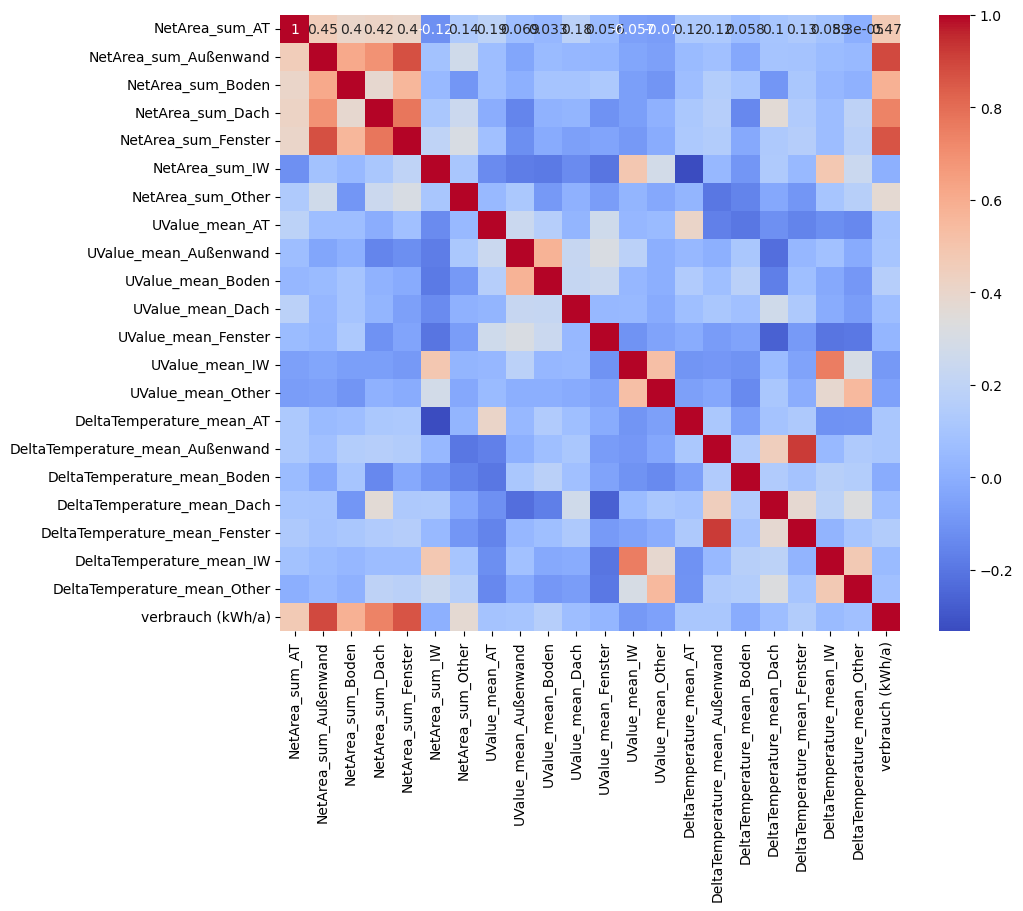

In [8]:
# Plot correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr = merged_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


## ML-Models

### Separate prediction target and features

In [9]:
# Separate features and target
X = merged_data.drop(columns=['verbrauch (kWh/a)']) 
y = merged_data['verbrauch (kWh/a)']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocess data

In [10]:
# Define the preprocessor and the pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


### Train XGBoost, Linear Regression & Random Forest

In [11]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Define the preprocessor and the pipeline for Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Define the preprocessor and the pipeline for Linear Regression
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the Linear Regression model
linear_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_linear = linear_model.predict(X_test)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))

# Define the preprocessor and the pipeline for XGBoost
xgboost_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_xgboost = xgboost_model.predict(X_test)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_xgboost))

# Store loss functions in table
loss_functions = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'XGBoost'],
    'MAE': [mae_rf, mae_linear, mae_xgboost],
    'RMSE': [rmse_rf, rmse_linear, rmse_xgboost]
})
loss_functions

,Model,MAE,RMSE
0,Random Forest,8151.340000,14307.260596
1,Linear Regression,11309.853552,15499.300681
2,XGBoost,9299.009062,14947.723985


In [13]:
# Compare to Baseline-Models
from sklearn.dummy import DummyRegressor

# Define the mean baseline model
mean_baseline = DummyRegressor(strategy='mean')

# Train the mean baseline model
mean_baseline.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_mean_baseline = mean_baseline.predict(X_test)
mae_mean_baseline = mean_absolute_error(y_test, y_pred_mean_baseline)
rmse_mean_baseline = np.sqrt(mean_squared_error(y_test, y_pred_mean_baseline))

# Define the median baseline model
median_baseline = DummyRegressor(strategy='median')

# Train the median baseline model
median_baseline.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_median_baseline = median_baseline.predict(X_test)
mae_median_baseline = mean_absolute_error(y_test, y_pred_median_baseline)
rmse_median_baseline = np.sqrt(mean_squared_error(y_test, y_pred_median_baseline))

# Add baseline model performance to the loss functions table
loss_functions = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'XGBoost', 'Mean Baseline', 'Median Baseline'],
    'MAE': [mae_rf, mae_linear, mae_xgboost, mae_mean_baseline, mae_median_baseline],
    'RMSE': [rmse_rf, rmse_linear, rmse_xgboost, rmse_mean_baseline, rmse_median_baseline]
})

print(loss_functions)

               Model           MAE          RMSE
0      Random Forest   8151.340000  14307.260596
1  Linear Regression  11309.853552  15499.300681
2            XGBoost   9299.009062  14947.723985
3      Mean Baseline  20311.191919  23075.523793
4    Median Baseline  15522.000000  19814.305438


## Hyperparameter Tuning

In [12]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the preprocessor and the pipeline for Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Define the parameter grid for Random Forest
param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

# Perform Grid Search with Cross Validation for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best score for Random Forest
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)

# Define the preprocessor and the pipeline for Linear Regression
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the Linear Regression model
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

# Define the preprocessor and the pipeline for XGBoost
xgboost_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 6, 9],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0]
}

# Perform Grid Search with Cross Validation for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgboost_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters and best score for XGBoost
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)

# Store loss functions in a table
loss_functions = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'XGBoost', 'Best Random Forest', 'Best XGBoost'],
    'MAE': [mae_rf, mae_linear, mae_xgboost, mae_best_rf, mae_best_xgb]
})

print(loss_functions)


                Model           MAE
0       Random Forest   8151.340000
1   Linear Regression  11309.853552
2             XGBoost   9299.009062
3  Best Random Forest   9193.440000
4        Best XGBoost   8964.422656
